In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Convolution2D, Flatten, Dropout,GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models,optimizers
from keras import layers
from tensorflow import keras
from keras import metrics
from keras.applications.inception_resnet_v2 import preprocess_input
from attention import AttentionLayer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
#import keras
import numpy as np
import warnings
warnings.filterwarnings('ignore')

2023-02-12 11:19:11.407482: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2023-02-12 11:19:13.027945: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-02-12 11:19:13.052639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 11:19:13.053244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:24:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.86GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2023-02-12 11:19:13.053269: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-02-12 11:19:13.055059: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-02-12 11:19:13.056559: I tensorflow/stream_executor/plat

In [3]:
def plotResults(history):
        
    # Accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('images/accuracy.png')
    plt.show()
    plt.close()
    
    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('images/loss.png')
    plt.show()
    plt.close()

In [4]:
datadir = "./data/akac_gen.txt"

In [5]:
dataset = pd.read_csv(datadir, delimiter ="\t", header = 0)
print(list(dataset.columns))
dataset = dataset.sample(frac=1,random_state=777)  # row 전체 shuffle

SNPs = ['rs2235375','rs1044516','rs11204737','rs1044516','rs7715100','rs3917192','rs2235371']
snps = ['rs906830', 'rs1537514', 'rs4252328', 'rs2235371', 'rs481931', 'rs3771485', 'rs4252328', 'rs9651118', 'rs11796677', 'rs2295221']

dataset.head()
del_list = ["famid", "pid", "fatid", "motid", "sex","rs12089548","rs11466414"]
for i in del_list:
    del dataset[i]

y_train = pd.to_numeric(dataset['affected']) -1
del dataset['affected']




['famid', 'pid', 'fatid', 'motid', 'sex', 'affected', 'rs3737967', 'rs1537514', 'rs2274976', 'rs1801131', 'rs1801133', 'rs9651118', 'rs3753582', 'rs4147871', 'rs560426', 'rs1209169', 'rs481931', 'rs12089548', 'rs16827741', 'rs2228099', 'rs11204737', 'rs3768012', 'rs7517566', 'rs1044516', 'rs599021', 'rs17317411', 'rs2235373', 'rs2235371', 'rs2235375', 'rs595918', 'rs17015218', 'rs2013162', 'rs3821272', 'rs930655', 'rs3732247', 'rs765871', 'rs3771498', 'rs3771497', 'rs3755377', 'rs3771485', 'rs11466212', 'rs3771475', 'rs1139', 'rs3821949', 'rs12532', 'rs4464513', 'rs698', 'rs1693482', 'rs2241894', 'rs2255796', 'rs7713638', 'rs7715100', 'rs15251', 'rs16873348', 'rs910586', 'rs2819861', 'rs1934328', 'rs987525', 'rs7078160', 'rs7940667', 'rs7103685', 'rs931953', 'rs10790330', 'rs906830', 'rs7129848', 'rs3935406', 'rs10892434', 'rs4409845', 'rs2136421', 'rs2295221', 'rs7142363', 'rs2073247', 'rs17104928', 'rs17176643', 'rs11156925', 'rs17104939', 'rs17104944', 'rs17104965', 'rs1884213', 'rs

In [6]:
dataset.head()

,rs3737967,rs1537514,rs2274976,rs1801131,rs1801133,rs9651118,rs3753582,rs4147871,rs560426,rs1209169,...,rs9890413,rs2965169,rs8100239,rs13041247,rs6029273,rs3577,rs6621539,rs11796677,rs1429591,rs195291
145,2,2,2,2,2,0,1,0,2,1,...,2,1,1,2,1,2,0,2,0,2
25,2,2,2,2,1,1,2,0,2,2,...,1,2,2,1,1,2,0,2,0,1
48,2,2,2,2,1,1,2,0,2,2,...,2,2,1,0,0,2,1,1,0,1
169,2,2,2,2,1,0,2,0,2,2,...,2,1,2,1,0,2,2,0,0,0
177,2,2,2,2,1,1,2,0,1,1,...,2,1,1,2,0,2,2,0,0,0


In [7]:
#from keras.utils import to_categorical
#y_train_np = to_categorical(y_train_np)
#print(y_train_np)

In [8]:
model = keras.models.load_model("./Ensemble/10snp2_ann.h5")
#model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
#model.evaluate(x_train_np, y_train_np, batch_size=200, verbose=2)
#model.evaluate(x_test_np, y_test_np, batch_size=100, verbose=2)


2023-02-12 11:19:13.142873: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 11:19:13.166462: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3599535000 Hz
2023-02-12 11:19:13.167419: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x537c010 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-12 11:19:13.167452: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-12 11:19:13.233627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-0

In [9]:
model1 = keras.models.load_model("./Ensemble/16snp1_ann-69-0.63.h5")
model2 = keras.models.load_model("./Ensemble/16snp2_ann-61-0.65.h5")
model3 = keras.models.load_model("./Ensemble/16snp3_ann-37-0.61.h5")
model4 = keras.models.load_model("./Ensemble/16snp4_ann-36-0.61.h5")
model5 = keras.models.load_model("./Ensemble/16snp5_ann-64-0.65.h5")
model6 = keras.models.load_model("./Ensemble/16snp6_ann-69-0.58.h5")

In [10]:
models = [model1,model2,model3,model4,model5,model6]

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
#model.load_weights("./model/16snp_ann-196-0.63.h5")
#test_loss, test_acc = model1.evaluate(x_train_np, y_train_np, batch_size=200, verbose=2)
predict_test =np.zeros((62,1))
predict_train =np.zeros((200,1))
raw_output_test=[]
raw_output_train=[]
num_train =200
SNPs = [['rs3771485', 'rs2235371', 'rs2013162', 'rs4252328', 'rs7129848', 'rs7940667', 'rs4464513', 'rs16873348', 'rs2819861', 'rs1934328', 'rs2284791', 'rs16827741', 'rs17317411', 'rs6029273', 'rs481931', 'rs11796677'],
           ['rs2235373','rs2013162','rs1044516','rs11204737','rs595918','rs16873348','rs3753582','rs2284791','rs3917192','rs7715100','rs13041247','rs1934328','rs1801131','rs7517566','rs2819861','rs4252328'],
           ['rs3771485', 'rs6029273', 'rs16873348', 'rs1429591', 'rs1537514', 'rs2241894', 'rs3821272', 'rs4147871', 'rs195291', 'rs17104944', 'rs16827741', 'rs2295221', 'rs2235375', 'rs1934328', 'rs3771498', 'rs1801131'],
           ['rs3771485', 'rs1537514', 'rs2235371', 'rs4252328', 'rs7129848', 'rs1044516', 'rs4464513', 'rs11796677', 'rs2819861', 'rs1934328', 'rs3821949', 'rs16827741', 'rs17317411', 'rs1801133', 'rs481931', 'rs11796677'],
           ['rs3771485', 'rs3821272', 'rs195291', 'rs4464513', 'rs481931', 'rs3917211', 'rs17104939', 'rs11156925', 'rs599021', 'rs2013162', 'rs2284791', 'rs931953', 'rs4252328', 'rs7129848', 'rs15251', 'rs2274976'],
       ['rs17104944', 'rs1537514', 'rs2013162', 'rs4252328', 'rs906830', 'rs7940667', 'rs4464513', 'rs16873348', 'rs15251', 'rs1934328', 'rs2284791', 'rs599021', 'rs11204737', 'rs6029273', 'rs481931', 'rs11796677']]
print(SNPs[0])
for i,j in zip(models,range(len(models))):
    X_train = dataset[SNPs[j]]
    x_train_np = np.array(X_train)[:num_train].astype("float")
    x_test_np = np.array(X_train)[num_train:].astype("float")
    y_train_np = np.array(y_train)[:num_train].astype("float")
    y_test_np = np.array(y_train)[num_train:].astype("float")
    
    i.evaluate(x_train_np, y_train_np, batch_size=200, verbose=2)
    i.evaluate(x_test_np, y_test_np, batch_size=100, verbose=2)
    predict_test+=i.predict(x_test_np, batch_size=100)
    predict_train+=i.predict(x_train_np, batch_size=100)
    raw_output_test.append(i.predict(x_test_np, batch_size=100))
    raw_output_train.append(i.predict(x_train_np, batch_size=100))
threshold = 6
print('test auc')
print(roc_auc_score(y_test_np, predict_test))
print('train auc')
print(accuracy_score(y_train_np, np.round(predict_train/threshold,0)))
print('test acc')
print(accuracy_score(y_test_np, np.round(predict_test/threshold,0)))
tn, fp, fn, tp = confusion_matrix(y_test_np, np.round(predict_test/threshold,0)).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
print('specificity')
print(specificity)
print('sensitivity')
print(sensitivity)

['rs3771485', 'rs2235371', 'rs2013162', 'rs4252328', 'rs7129848', 'rs7940667', 'rs4464513', 'rs16873348', 'rs2819861', 'rs1934328', 'rs2284791', 'rs16827741', 'rs17317411', 'rs6029273', 'rs481931', 'rs11796677']
1/1 - 0s - loss: 0.0054 - accuracy: 0.9950
1/1 - 0s - loss: 0.3402 - accuracy: 0.6290


2023-02-12 11:19:14.160772: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


1/1 - 0s - loss: 0.0351 - accuracy: 0.9450
1/1 - 0s - loss: 0.2709 - accuracy: 0.6452
1/1 - 0s - loss: 0.0309 - accuracy: 0.9750
1/1 - 0s - loss: 0.2986 - accuracy: 0.6129
1/1 - 0s - loss: 0.0036 - accuracy: 1.0000
1/1 - 0s - loss: 0.3313 - accuracy: 0.6129
1/1 - 0s - loss: 7.0643e-04 - accuracy: 1.0000
1/1 - 0s - loss: 0.3086 - accuracy: 0.6452
1/1 - 0s - loss: 0.0053 - accuracy: 0.9950


1/1 - 0s - loss: 0.3336 - accuracy: 0.5806
test auc
0.7437908496732026
train auc
1.0
test acc
0.6935483870967742
specificity
0.7058823529411765
sensitivity
0.6888888888888889


In [20]:
print('Classification Report')
print(classification_report(y_test_np, np.round(predict_test/6,0), target_names=['0','1'], digits=4))
print(classification_report(y_test_np, np.round(raw_output_test[1],0), target_names=['0','1'], digits=4))

Classification Report
              precision    recall  f1-score   support

           0     0.4615    0.7059    0.5581        17
           1     0.8611    0.6889    0.7654        45

    accuracy                         0.6935        62
   macro avg     0.6613    0.6974    0.6618        62
weighted avg     0.7516    0.6935    0.7086        62

              precision    recall  f1-score   support

           0     0.3913    0.5294    0.4500        17
           1     0.7949    0.6889    0.7381        45

    accuracy                         0.6452        62
   macro avg     0.5931    0.6092    0.5940        62
weighted avg     0.6842    0.6452    0.6591        62



0.6496732026143791
[0.         0.         0.         0.05882353 0.05882353 0.11764706
 0.11764706 0.17647059 0.17647059 0.23529412 0.23529412 0.29411765
 0.29411765 0.41176471 0.41176471 0.47058824 0.47058824 0.52941176
 0.52941176 0.58823529 0.58823529 0.76470588 0.76470588 1.        ]
[0.         0.02222222 0.06666667 0.06666667 0.26666667 0.26666667
 0.33333333 0.33333333 0.6        0.6        0.66666667 0.66666667
 0.68888889 0.68888889 0.71111111 0.71111111 0.75555556 0.75555556
 0.93333333 0.93333333 0.97777778 0.97777778 1.         1.        ]
[0.         0.         0.         0.05882353 0.05882353 0.11764706
 0.11764706 0.17647059 0.17647059 0.23529412 0.23529412 0.29411765
 0.29411765 0.35294118 0.35294118 0.41176471 0.41176471 0.47058824
 0.47058824 0.52941176 0.52941176 0.58823529 0.58823529 0.64705882
 0.64705882 0.70588235 0.70588235 0.82352941 0.82352941 1.        ]
[0.         0.02222222 0.06666667 0.06666667 0.11111111 0.11111111
 0.26666667 0.26666667 0.33333333 0.3333

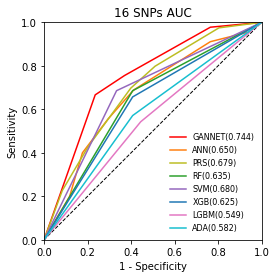

In [23]:
from sklearn.metrics import roc_curve, auc

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test_np, predict_test)
t, o, _ = roc_curve(y_test_np, raw_output_test[1])
print(roc_auc_score(y_test_np, raw_output_test[1]))
print(nn_fpr_keras)
print(nn_tpr_keras)
print(t)
print(o)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.gca().set_aspect('equal', adjustable='box')

plt.title('16 SNPs AUC')
plt.plot([0,0.1176,0.2352,0.37,0.7647,1], [0,0.3333,0.6666,0.7555,0.9777,1], label='GANNET(0.744)',color='r')
plt.plot([0,0.1176,0.1764,0.2941,0.4117,0.7647,0.9411,1], [0,0.2,0.4,0.5555,0.6888,0.9111,0.9555,1], label='ANN(0.650)',color='C1')
plt.plot([0,0.0839,0.2027,0.3986,0.5104,0.8041,1], [0,0.2268,0.4285,0.6974,0.7983,0.9747,1], label='PRS(0.679)', color = 'C8')
plt.plot([0.,0.4074,1.], [0.,0.6857,1.], label='RF(0.635)',color='C2')
plt.plot([0.,0.3333,1.], [0.,0.6857,1.], label='SVM(0.680)',color='C4')
plt.plot([0.,0.4074,1.], [0.,0.6571,1.], label='XGB(0.625)',color='C0')
#plt.plot([0.,0.4815,1.], [0.,0.6,1.], label='LR(0.559)', color = 'C5')
plt.plot([0.,0.4444,1.], [0.,0.5429,1.], label='LGBM(0.549)', color = 'C6')
plt.plot([0.,0.4074,1.], [0.,0.5714,1.], label='ADA(0.582)', color = 'C9')

plt.legend(loc='best',frameon=False, prop={'size': 8})
plt.savefig("./figure/16snp_roc1.png",dpi=300)